# MA - INF 2201 - Computer Vision WS 22/23

### Exercise Sheet 02


In [1]:
import cv2 as cv
import numpy as np
import os
import time
from matplotlib import pyplot as plt

DATA_DIR = '../data'
SIM_THRESHOLD = 0.5 # similarity threshold for template matching. Can be adapted.


### 1. Fourier Transform 

In this task, we will show a useful property of the Fourier Transform, which is the convolution property. It tells us that convolution in the spatial domain corresponds to multiplication in the frequency domain. The input image that you will be operating on is orange.jpeg and celeb.jpeg.

- Load the two images orange.jpeg and celeb.jpeg. Remember to convert to grayscale.
- Create a 7 × 7 Gaussian kernel with sigma=1.
- Blur the images by convolving the image with the Gaussian kernel directly in the spatial domain. You may use the library function (cv2.filter2D).
- Now we are going to blur the images in the frequency domain using Fourier Transform. We multiply the kernel function and the frequency image instead of applying convolution. To get the final result, we transform back to the image space. You may use functions included in the package numpy.fft to apply the transform and its inverse.
- Visualise the results for both images and report the mean absolute difference between the two blurring methods and the time taken by each of them.
    
(3 Points)

time taken to apply blur in the spatial domain 0.002065896987915039
time taken to apply blur in the frequency domain 0.022925853729248047
mean square difference: 4.920509154454108
time taken to apply blur in the spatial domain 0.0001823902130126953
time taken to apply blur in the frequency domain 0.02028203010559082
mean square difference: 4.311900834965467


[]

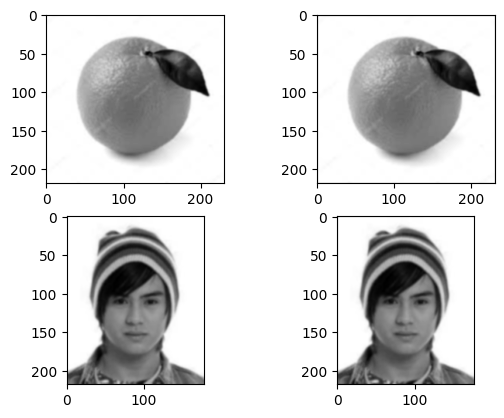

In [2]:
# blur the image in the spatial domain using convolution
def blur_im_spatial(image, kernel_size):
    return cv.GaussianBlur(image, ksize=[kernel_size, kernel_size], sigmaX=1, sigmaY=1)
    

# blur the image in the frequency domain
def blur_im_freq(image, kernel):
    # edge case: if image is even numbered shape change to odd number
    pad_img = image
    dim1_pad, dim2_pad = 0, 0
    if pad_img.shape[0] % 2 == 0:
        pad_img = np.pad(pad_img, pad_width=((0, 1), (0, 0)), mode="edge")
        dim1_pad = 1
    if pad_img.shape[1] % 2 == 0:
        pad_img = np.pad(pad_img, pad_width=((0, 0), (0, 1)), mode="edge")
        dim2_pad = 1

    # steps: 
    # 1. create 2D kernel of any size (U x V)
    # 2. zero-pad the kernel up to (M+U-1) x (N+V-1)
    pad_kernel = np.pad(
        kernel, 
        pad_width=(
            ((pad_img.shape[0] - 1)//2, (pad_img.shape[0] - 1)//2), 
            ((pad_img.shape[1] - 1)//2, (pad_img.shape[1] - 1)//2)
            ), 
        mode="constant"
        )

    # 3. take the 2-D fft of the kernel
    freq_kernel = np.fft.fft2(pad_kernel)
    # 4. zero-pad the image up to (M+U-1) x (N+V-1)
    pad_img = np.pad(
        pad_img, 
        pad_width=(
            ((kernel.shape[0] - 1)//2, (kernel.shape[0] - 1)//2),
            ((kernel.shape[1] - 1)//2, (kernel.shape[1] - 1)//2)
            ),
        mode="constant"
        )
    # 5. take the 2-D FFT of the image
    freq_img = np.fft.fft2(pad_img)
    # 6. multiply FFT of kernel by FFT of image
    blur_img = freq_img * freq_kernel
    # 7. take inverse 2-D FFT of result
    blur_img = np.fft.ifft2(blur_img)

    blur_img = np.fft.ifftshift(np.round(np.real(blur_img)))
    # 8. trim off garbage at edges + edge case if dims are even
    blur_img = blur_img[(kernel.shape[0] - 1)//2 : - ((kernel.shape[0] - 1)//2 + dim1_pad), (kernel.shape[1] - 1)//2 : -((kernel.shape[1] - 1)//2 + dim2_pad)]
    assert blur_img.shape == image.shape, print("error", blur_img.shape, image.shape)

    return blur_img

def task1(input_im_file):
    full_path = os.path.join(DATA_DIR, input_im_file)
    image = cv.imread(full_path, cv.IMREAD_GRAYSCALE)
    kernel_size = 7
    # create 1 dim kernel
    kernel = cv.getGaussianKernel(ksize=49, sigma=1)
    # outer product for 7x7 kernel
    kernel = np.outer(kernel, kernel)
    # time the blurring of the different methods
    start_time = time.time()
    conv_result = blur_im_spatial(image, kernel_size) 
    end_time = time.time()
    print('time taken to apply blur in the spatial domain', end_time-start_time)
    # measure the timing here too
    start_time = time.time()
    fft_result = blur_im_freq(image, kernel)
    end_time = time.time()
    print('time taken to apply blur in the frequency domain', end_time-start_time)
    print("mean square difference:", (cv.absdiff(conv_result.astype("uint8"), fft_result.astype("uint8"))**2).mean())

    return conv_result, fft_result

orange_conv, orange_fft = task1('orange.jpeg')
celeb_conv, celeb_fft = task1('celeb.jpeg')

_, ax = plt.subplots(2, 2)
ax[0][0].imshow(orange_conv, cmap="gray")
ax[0][1].imshow(orange_fft, cmap="gray")
ax[1][0].imshow(celeb_conv, cmap="gray")
ax[1][1].imshow(celeb_fft, cmap="gray")
plt.plot()



### 2. Template Matching 
In this task, we will implement template matching using Sum Square Difference and normalized cross-correlation similarity measures. The input image is RidingBike.jpeg and the template image (what we want to find in the larger input image) is RidingBikeTemplate.jpeg

- Implement Sum Square Difference.
- Implement template matching using your implementation of Sum Square Difference.
- Implement Normalized Cross-correlation.
- Implement template matching using Normalized Cross-correlation.
- Draw rectangles on the image where similarity ≥0.5 for both methods. You may experiment with other threshold values to determine the matching.

(3 Points)

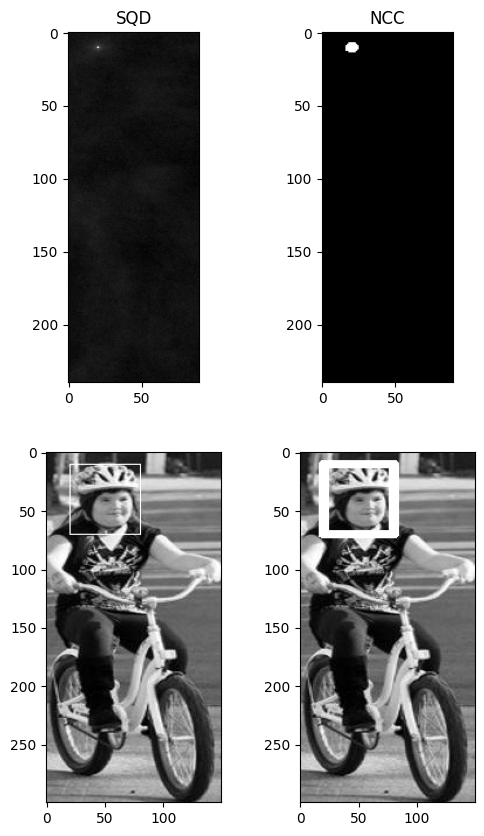

In [3]:
# implement the sum square difference (SQD) similarity 
def calc_sum_square_difference(image, template):
    k, l = template.shape
    output = np.zeros([image.shape[0]-k, image.shape[1]-l])

    for n in range(image.shape[0] - l ):
        for m in range(image.shape[1] - k ):
            output[n][m] = np.sum(np.subtract(template, image[n:n+l, m:m+k])**2)
    
    return output

       
# implement the normalized cross correlation (NCC) similarity 
# Weirdly splitting this function to have less work in Task 3 :)
def calc_normalized_cross_correlation_at_pos(image, template, m,n):
    # DEBUG: print("Pos:",m,n)
    k, l = template.shape
    tmp = image[m:m+k, n:n+l]
    _mean_image_patch = (np.full((k,l), np.mean(tmp)))

    # Calculate the mean of template and create Array with it
    _mean_template = (np.full((k,l), np.mean(template)))
    _template = np.subtract(template, _mean_template)
    _image = np.subtract(tmp, _mean_image_patch)


    top = np.sum(_template * _image)
    bot = (np.sum(_template**2) * np.sum(_image**2)) ** 0.5

    return round(top / bot)

def calc_normalized_cross_correlation(image, template):
    k, l = template.shape
    output = np.zeros([image.shape[0]-k, image.shape[1]-l])

    for m in range(image.shape[0] - k -1):
        for n in range(image.shape[1] - l -1):
            output[m][n] = calc_normalized_cross_correlation_at_pos(image, template, m,n)
    
    return output

#draw rectanges on the input image in regions where the similarity is larger than SIM_THRESHOLD
def draw_rectangles(input_im, similarity_im, size=(60,60)):
    output = input_im.copy()
    for x in range(similarity_im.shape[0]):
        for y in range(similarity_im.shape[1]):
            if(similarity_im[x][y] > SIM_THRESHOLD):
                cv.rectangle(output, (y, x), (y+size[0], x+size[1]), (255,0,0), 1)
    
    return output

#Template matching using single-scale
def task2(input_im_file, template_im_file):
    full_path_im = os.path.join(DATA_DIR, input_im_file)
    full_path_template = os.path.join(DATA_DIR, template_im_file)
    in_im = cv.imread(full_path_im, cv.IMREAD_GRAYSCALE)
    template = cv.imread(full_path_template, cv.IMREAD_GRAYSCALE)
    result_sqd = calc_sum_square_difference(in_im, template)
    result_sqd = 1 - result_sqd / np.amax(result_sqd)

    result_ncc = calc_normalized_cross_correlation(in_im, template)
    result_ncc = result_ncc / np.amax(result_ncc)


    #draw rectanges at matching regions
    vis_sqd = draw_rectangles(in_im, result_sqd)
    vis_ncc = draw_rectangles(in_im, result_ncc)

    _, ax = plt.subplots(2, 2, figsize=(6, 10))
    ax[0,0].set_title("SQD")
    ax[0,0].imshow(result_sqd, cmap="gray", norm=None)
    ax[0,1].set_title("NCC")
    ax[0,1].imshow(result_ncc, cmap="gray", norm=None)
    ax[1,0].imshow(vis_sqd, cmap="gray", norm=None)
    ax[1,1].imshow(vis_ncc, cmap="gray", norm=None)


task2('RidingBike.jpeg', 'RidingBikeTemplate.jpeg')

### 3. Template matching multi-scale 

In this task, we will build the Gaussian pyramid to make template matching work at different resolutions. Read the image DogGray.jpeg and the template DogTemplate.jpeg
- Build a 5 level Gaussian pyramid by downsampling put image yourself.
- Now create a 5 level Gaussian pyramid using cv2.pyrDown. Compare it with your implementation by printing the mean absolute difference at each level.
- Perform template matching by using your implementation of normalized crosscorrelation . Report the time taken by this method.
- Show the template matching using normalized cross correlation at the different Pyramid levels of both the template and input images (you can use the pyramid obtained by pyrDown).
- As you observed, implementing template matching naively is not efficient. Now we will rely on the pyramid technique while constraining the search space in order to make it faster. Follow the procedure described in the lecture slides: search only in regions with high similarity in the previous pyramid level. Compare the times taken by this method and the naive implementation.
- Visualise the template matching results.

(6 Points)

In [4]:
def stepPyramidDown(im):
    image = cv.GaussianBlur(im, (5,5), 0)
    return image[::2,::2]

def pyramidTemplateMatching(imgs, templates):
    # Find matching areas in highest layer (smallest image)
    img = imgs[-1]
    temp = templates[-1]
    res = calc_normalized_cross_correlation(img, temp)
    # Get all matching locations; multiply coordinates with 2 for next bigger layer
    pos = np.argwhere(res>SIM_THRESHOLD)
    # DEBUG: print(pos)
    pos = pos*2

    # Go trough rest of layers and apply same procedure
    for i in range(len(imgs)-1)[::-1]:
        # DEBUG: print(pos)
        nexpos = []
        for x,y in pos:
            img = imgs[i]
            temp = templates[i]
            res = calc_normalized_cross_correlation_at_pos(img, temp, x, y)
            if(res > SIM_THRESHOLD):
                nexpos.append((x*2,y*2))

        pos = nexpos

    return pos

In [5]:
# task3('DogGray.jpeg', 'DogTemplate.jpeg')
input_im_file = 'DogGray.jpeg'
template_im_file = 'DogTemplate.jpeg'

full_path_im = os.path.join(DATA_DIR, input_im_file)
full_path_template = os.path.join(DATA_DIR, template_im_file)
in_im = cv.imread(full_path_im, cv.IMREAD_GRAYSCALE)
template = cv.imread(full_path_template, cv.IMREAD_GRAYSCALE)

# Prepare Template Pyramid for later use
template_pyramid = []
template_pyramid.append(template.copy())
for i in range(4):
    template_pyramid.append(stepPyramidDown(template_pyramid[i]))

In [6]:
# Build a 5 level Gaussian pyramid by downsampling the input image
print("# Creating self implemented pyramid")
self_pyramid = []
self_pyramid.append(in_im.copy())
for i in range(4):
    self_pyramid.append(stepPyramidDown(self_pyramid[i]))


# Use cv.pyrDown() and compare with self implemented
print("\n# Use cv.pyrDown() and compare with self implemented")
cv_pyramid = []
cv_pyramid.append(in_im.copy())
for i in range(4):
    cv_pyramid.append(cv.pyrDown(cv_pyramid[i]))
    print("Mean difference on level",i+1,"is:", np.mean(np.subtract(self_pyramid[i], cv_pyramid[i])))

# Creating self implemented pyramid

# Use cv.pyrDown() and compare with self implemented
Mean difference on level 1 is: 0.0
Mean difference on level 2 is: 0.0
Mean difference on level 3 is: 0.0
Mean difference on level 4 is: 0.0



# Perform template matching by using your implementation of normalized cross correlation
> time taken to perform NCC in seconds: 11.892383337020874

# template matching using normalized cross correlation at different Pyramid levels


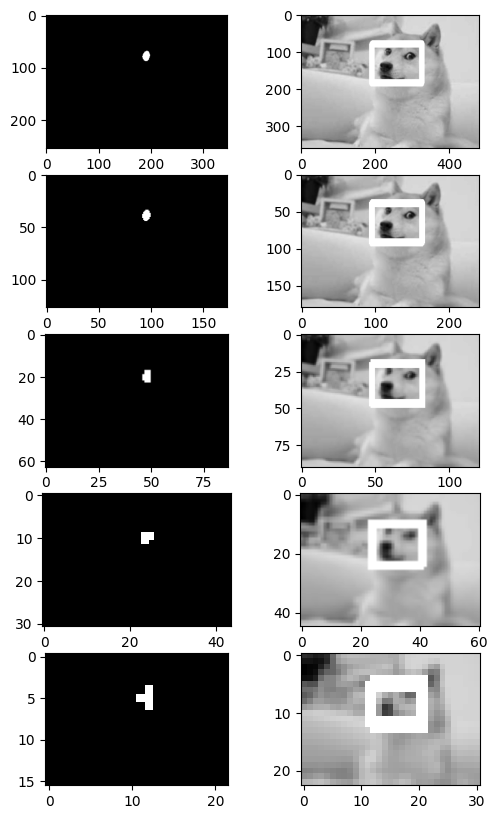

In [7]:
print("\n# Perform template matching by using your implementation of normalized cross correlation")
start_time = time.time()
some_not_that_useless_result = calc_normalized_cross_correlation(in_im, template)
end_time = time.time()
print('> time taken to perform NCC in seconds:', end_time-start_time) # about 20s on my machine

# template matching using normalized cross correlation
print("\n# template matching using normalized cross correlation at different Pyramid levels")


_, ax = plt.subplots(5, 2, figsize=(6, 10))
ax[0,0].imshow(some_not_that_useless_result, cmap="gray", norm=None)
ax[0,1].imshow(draw_rectangles(in_im, some_not_that_useless_result, (template.shape[::-1])), cmap="gray", norm=None)

for i in range(4):
    tmp = calc_normalized_cross_correlation(self_pyramid[i+1], template_pyramid[i+1])
    ax[i+1,0].imshow(tmp, cmap="gray", norm=None)
    ax[i+1,1].imshow(draw_rectangles(self_pyramid[i+1], tmp, (template_pyramid[i+1].shape[::-1])), cmap="gray", norm=None)


# Using the method described in the lecture to search smarter, not harder
> Wow! This only less than a second, to be exact: 0.02968597412109375 meaning, this is a lot faster!
Found Doggy Face at: 80 192


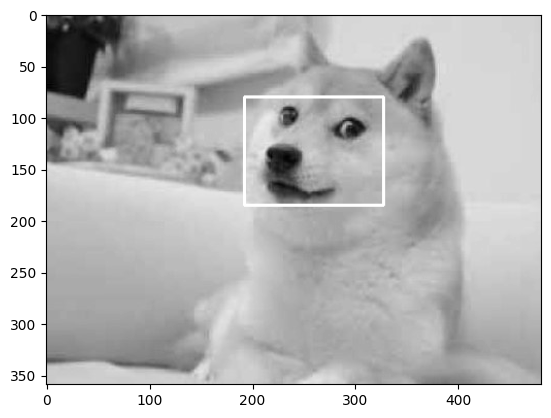

In [8]:
print("# Using the method described in the lecture to search smarter, not harder")
start_time = time.time()
pos = pyramidTemplateMatching(self_pyramid, template_pyramid)
end_time = time.time()
print("> Wow! This only less than a second, to be exact:", (end_time-start_time), "meaning, this is a lot faster!")

doggy_coppy = in_im.copy()
for x,y in pos: 
    x = int(x/2)
    y = int(y/2)
    print("Found Doggy Face at:",x,y)
    cv.rectangle(doggy_coppy, (y,x), (y+template.shape[1], x+template.shape[0]), (255,0,0), 2) # (I hate Index-swapping-errors!)

plt.imshow(doggy_coppy, cmap="gray")

### 4. Pyramids for image blending 

In this task, we will stitch two images using pyramids. Without pyramids, blending does not look natural because of discontinuities between the pixel values. We will blend the images dog.jpeg and moon.jpeg.
- Load the two images dog.jpeg and moon.jpeg.
- Create the Gaussian Pyramids of the two images, and find their Laplacian Pyramids LA and LB (remember that a Laplacian Pyramid is the difference between two levels in the Gaussian Pyramid as explained in the lecture, i.e. Li = Gi −expand(Gi+1)). Set the number of levels to 5.
- Blend the image dog.jpeg with the image moon.jpeg: create a Gaussian pyramid GR for the region of interest in the given mask mask.jpeg (first transform the mask to grayscale).
- Combine the Laplacian pyramids using GR as weights for the blending, i.e. LSl(i,j) = GRl(i,j) ·LAl(i,j) + (1 −GRl(i,j)) ·LBl(i,j)
- Collapse the LS pyramid to obtain the final composite image: LSl = LSl + expand(LSl+1). Apply the blending operation on the images inside task4 (the results will be funny).

(6 Points)

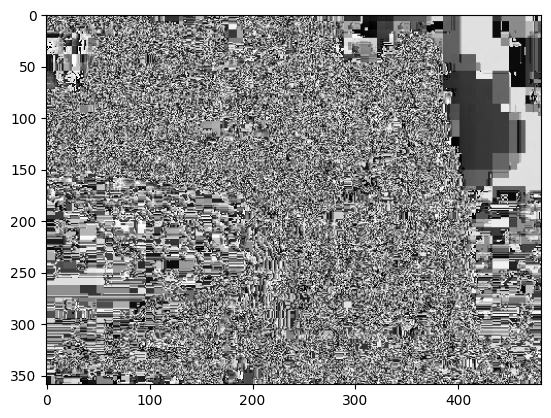

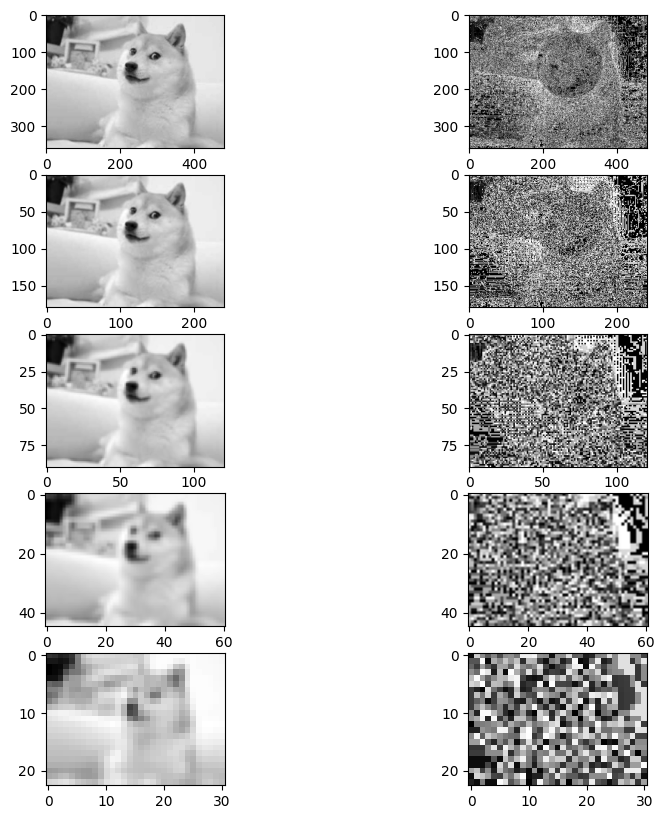

In [13]:
#You can choose to resize the image using the new dimensions or the scaling factor
def pyramid_down(image, dstSize, scale_factor=None):   
    pass

#create a pyramid of the image using the specified pyram function pyram_method.
#pyram_func can either be cv.pyrDown or your own implementation
def create_gaussian_pyramid(image, num_levels):
    #create list for pyramid
    pyr_list = []
    pyr_list.append(image)
    for i in range(1, num_levels):
        pyr_list.append(cv.pyrDown(pyr_list[i-1]))
    return pyr_list
    

def create_laplacian_pyramid(image, num_levels=5):
    #create the laplacian pyramid using the gaussian pyramid
    gaussian_pyramid = create_gaussian_pyramid(image, num_levels)
    
    # n level is the same for laplace and gaussian
    laplace_pyramid = gaussian_pyramid.copy()
    for i in reversed(range(1, len(gaussian_pyramid))):
        # upsampling without cv.pyrup because that would take away the sense of this exercise
        expanded_img = gaussian_pyramid[i].repeat(2, axis=0).repeat(2, axis=1)

        # check if upsampling size is correct otherwise crop
        if (expanded_img.shape != gaussian_pyramid[i-1].shape):
            dim1_diff, dim2_diff = np.subtract(expanded_img.shape, gaussian_pyramid[i-1].shape)
            expanded_img = expanded_img[dim1_diff:, dim2_diff:]

        # L_i-1 = G_i-1 - expand(G_i)
        laplace_pyramid[i-1] = cv.absdiff(gaussian_pyramid[i-1], expanded_img)
            
    return gaussian_pyramid, laplace_pyramid

# Given the final weighted pyramid, sum up the images at each level with the upscaled previous level
def collapse_pyramid(laplacian_pyramid):

    final_im = laplacian_pyramid[0]
    for l in range(1, len(laplacian_pyramid)):
        # upscale
        expanded_img = laplacian_pyramid[l].repeat(2**l, axis=0).repeat(2**l, axis=1)

        # check if upsampling size is correct otherwise crop
        if (expanded_img.shape != laplacian_pyramid[0].shape):
            dim1_diff, dim2_diff = np.subtract(expanded_img.shape, laplacian_pyramid[0].shape)
            expanded_img = expanded_img[dim1_diff:, dim2_diff:]
        # collapse
        final_im = final_im + expanded_img
            
    return final_im



#Image blending
def task4(input_im_file1, input_im_file2, interest_region_file, num_pyr_levels=5):
    image_dog = cv.imread(DATA_DIR + "/" + input_im_file1, cv.IMREAD_GRAYSCALE)
    image_moon = cv.imread(DATA_DIR + "/" + input_im_file2, cv.IMREAD_GRAYSCALE)
    image_mask = cv.imread(DATA_DIR + "/" + interest_region_file, cv.IMREAD_GRAYSCALE)

    GA, LA = create_laplacian_pyramid(image_dog, num_pyr_levels)
    GB, LB = create_laplacian_pyramid(image_moon, num_pyr_levels)
    GR, LR = create_laplacian_pyramid(image_mask, num_pyr_levels)
    # LA = dog, LB = moon, GR = mask
    # LS_i = GR_i * LA_i + (1 - GR_i) * LB_i
    
    LS = [None] * num_pyr_levels
    for i in range(num_pyr_levels):
        LS[i] = GA[i] * LA[i] + (1 - GR[i]) * LB[i]

    # there seems to be some error, can't find it
    final_img = collapse_pyramid(LS)
    plt.imshow(final_img, cmap="gray")

    _, ax = plt.subplots(num_pyr_levels, 2, figsize=(10,10))
    for i in range(num_pyr_levels):
        ax[i][0].imshow(GA[i], cmap="gray")
        ax[i][1].imshow(LS[i], cmap="gray")
    result = None
    return result

task4('dog.jpeg', 'moon.jpeg', 'mask.jpeg')
# just for fun, blend these these images as well
# for i in range[1,2,10]:
# for i in [1, 2, 10]:
#     ind = str(i).zfill(2)
#     blended_im = task4('task4_extra/source_%s.jpg'%ind, 'task4_extra/target_%s.jpg'%ind, 'task4_extra/mask_%s.jpg'%ind)
#     #visualise the blended image

### 5. Edges 

In this task, we will detect edges in images using the derivative of a Gaussian kernel. Read the image einstein.jpeg.

- Compute the weights of the derivative (in x) of a 5x5 Gaussian kernel with σ = 0.6.
- Compute the weights of the derivative (in y) of a 5x5 Gaussian kernel with σ = 0.6.
- To get the edges, convolve the image with the kernels computed in previous steps. You can use cv2.filter2D.
- Compute the edge magnitude and the edge direction (you can use numpy.arctan2). Visualise the magnitude and direction.

(2 Points)


$$

g(x, \sigma) = \frac{1}{\sigma \sqrt{2\pi}}e^{- \frac{x^2}{2\sigma^2}} \\

\frac{\partial g(x, \sigma)}{\partial x} = \frac{x}{\sigma^3 \sqrt{2\pi}}e^{- \frac{x^2}{2\sigma^2}}

$$

(1, 5) (5, 1)


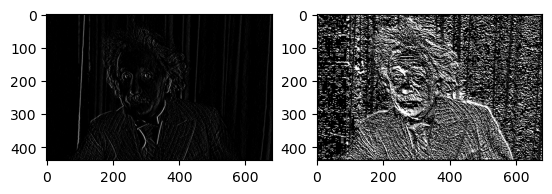

In [10]:

def calc_derivative_gaussian_kernel(size, sigma):
    # partial derivative of a gaussian kernel is the gaussian kernel 
    # multiplied by -x/sigma^2 by chain rule (credits to stack overflow)
    g_kernel = cv.getGaussianKernel(ksize = size, sigma=sigma)
    g_kernel_deriv = np.zeros_like(g_kernel)
    half_kernel_size = int(size / 2)
    for i in range(size):
        x = - half_kernel_size + i
        factor = - x / (sigma**2)
        g_kernel_deriv[i] = g_kernel[i] * factor
    return g_kernel_deriv.T, g_kernel_deriv

def task5(input_img, kernel_size=5, sigma=0.6):
    image = cv.imread("../data/" + input_img, 0)

    kernel_x, kernel_y = calc_derivative_gaussian_kernel(kernel_size, sigma)

    print(kernel_x.shape, kernel_y.shape)

    edges_x = cv.filter2D(image, ddepth=-1, kernel=kernel_x).astype(float)
    edges_y = cv.filter2D(image, ddepth=-1, kernel=kernel_y).astype(float)

    # magnitude computed as sqrt(edges_x^2, edges_y^2)
    magnitude = np.sqrt(edges_x**2, edges_y**2)
    direction = np.arctan2(edges_y, edges_x)

    _, ax = plt.subplots(1,2)
    ax[0].imshow(magnitude, cmap="gray")
    ax[1].imshow(direction, cmap="gray")



task5('einstein.jpeg')